In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, PolynomialFeatures
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.pipeline import Pipeline

https://stackoverflow.com/questions/77708524/python-fitting-polynomial-to-natural-log-then-reversing-the-transformation-back

In [2]:
np.random.seed(12345)
x = np.linspace(-1, 1, 50).reshape(-1, 1)
P = np.poly1d([6, 5, 4, 3, 2, 10])
y = P(x[:, 0])
n = 0.5 * np.random.randn(y.size)
yn = y + n

In [3]:
pipeline_lin = Pipeline([
    ("transformer", PolynomialFeatures(5)),
    ("model", LinearRegression(fit_intercept=False))
])

In [4]:
pipeline_lin.fit(x, yn)

Pipeline(steps=[('transformer', PolynomialFeatures(degree=5)),
                ('model', LinearRegression(fit_intercept=False))])

In [5]:
pipeline_lin["model"].coef_

array([10.0226118 ,  1.51830909,  2.23638955,  2.91665499,  5.99904944,
        7.88614861])

In [6]:
pipeline_log = Pipeline([
    ("transformer", PolynomialFeatures(5)),
    ("model",
         TransformedTargetRegressor(
             regressor=LinearRegression(fit_intercept=False),
             func=np.log,
             inverse_func=np.exp
         )
    )
])

In [7]:
pipeline_log.fit(x, yn)

Pipeline(steps=[('transformer', PolynomialFeatures(degree=5)),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=LinearRegression(fit_intercept=False)))])

In [8]:
pipeline_log["model"].regressor_.coef_

array([ 2.2901081 ,  0.15049063,  0.46685674,  0.32678866, -0.12522207,
        0.34130133])

In [9]:
pipeline_gpr = Pipeline([
    ("model",
         TransformedTargetRegressor(
             regressor=GaussianProcessRegressor(
                 kernel=1.0*RBF(),
                 alpha=0.01
             ),
             func=np.log,
             inverse_func=np.exp
         )
    )
])

In [10]:
pipeline_gpr.fit(x, yn)

Pipeline(steps=[('model',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=GaussianProcessRegressor(alpha=0.01,
                                                                               kernel=1**2 * RBF(length_scale=1))))])

In [11]:
xlin = np.linspace(-1, 1, 200).reshape(-1, 1)
yh_lin = pipeline_lin.predict(xlin)
yh_log = pipeline_log.predict(xlin)
yh_gpr = pipeline_log.predict(xlin)

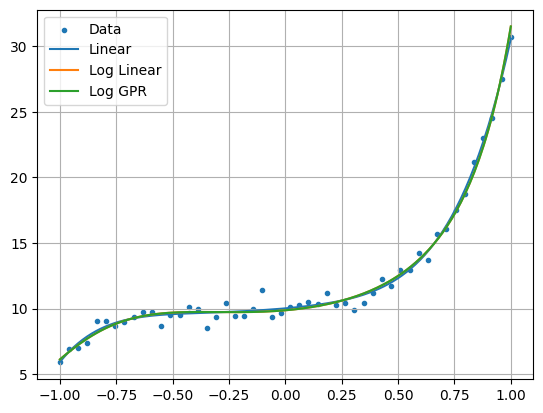

In [12]:
fig, axe = plt.subplots()
axe.scatter(x, yn, marker=".", label="Data")
axe.plot(xlin, yh_lin, label="Linear")
axe.plot(xlin, yh_log, label="Log Linear")
axe.plot(xlin, yh_gpr, label="Log GPR")
axe.legend()
axe.grid()

In [13]:
pipeline_log.fit(x, yn).predict(xlin)

array([ 6.1298002 ,  6.27679911,  6.42141645,  6.56349365,  6.70288339,
        6.83944982,  6.97306864,  7.1036271 ,  7.23102403,  7.35516966,
        7.47598559,  7.5934045 ,  7.70736999,  7.81783627,  7.92476789,
        8.02813934,  8.12793476,  8.22414749,  8.31677969,  8.40584193,
        8.49135273,  8.57333811,  8.65183118,  8.72687164,  8.79850537,
        8.86678394,  8.93176419,  8.9935078 ,  9.05208083,  9.10755331,
        9.15999885,  9.20949424,  9.25611902,  9.29995519,  9.34108681,
        9.37959966,  9.41558095,  9.449119  ,  9.48030295,  9.5092225 ,
        9.53596764,  9.56062846,  9.58329488,  9.60405645,  9.62300221,
        9.64022047,  9.65579866,  9.66982321,  9.68237941,  9.69355127,
        9.70342146,  9.71207118,  9.71958012,  9.72602634,  9.73148626,
        9.73603459,  9.73974429,  9.74268656,  9.74493077,  9.74654451,
        9.74759353,  9.74814175,  9.7482513 ,  9.74798248,  9.74739381,
        9.74654203,  9.74548214,  9.74426742,  9.74294947,  9.74